Data File: https://raw.githubusercontent.com/vjavaly/Baruch-CIS-3920/main/data/liver_cirrhosis_stage_10K.csv

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Load data

Features
* N_Days : # days between registration and the earlier of death, transplantation, or study analysis time in 1986
* Status : patient status - values = C (censored), CL (censored due to liver tx), or D (death)
* Drug : type of drug given (D-penicillamine) or placebo
* Age : patient age (days)
* Gender : M (male) or F (female)
* Ascites : presence of ascites N (No) or Y (Yes)
* Hepatomegaly : presence of hepatomegaly N (No) or Y (Yes)
* Spiders : presence of spiders N (No) or Y (Yes)
* Edema : presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
* Bilirubin : serum bilirubin in [mg/dl]
* Cholesterol : serum cholesterol in [mg/dl]
* Albumin : albumin in [gm/dl]
* Copper : urine copper in [ug/day]
* Alk_Phos : alkaline phosphatase in [U/liter]
* SGOT : serum glutamic-oxaloacetic transaminase, an enzyme level indicating liver health in [U/ml]
* Tryglicerides : triglicerides in [mg/dl]
* Platelets : platelets per cubic [ml/1000]
* Prothrombin : prothrombin time in seconds [s]
* Patient_ID : patient ID

Target variable to predict:
* Disease_Stage: stage_1, stage_2, stage_3

# Step One: Data Examination

In [3]:
#Reading the data file.
df = pd.read_csv('https://raw.githubusercontent.com/vjavaly/Baruch-CIS-3920/main/data/liver_cirrhosis_stage_10K.csv', sep=';', index_col='Patient_ID')

In [4]:
#To display all columns without truncation
pd.set_option('display.max_columns', None)

In [ ]:
#Reviewing the dataframe shape
df.shape

(10000, 19)

In [ ]:
#Displaying a sample of 5 rows from dataframe
df.sample(5)

,N_Days,Status,Drug,Age,Gender,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Disease_Stage
Patient_ID,,,,,,,,,,,,,,,,,,,
9778,1874.0,C,Placebo,24257.0,F,N,N,N,S,0.6,369.510563,3.35,97.648387,1982.655769,122.556346,124.702128,295.0,9.8,stage_1
9871,1347.0,CL,Placebo,20736.0,F,N,N,N,N,1.7,369.510563,3.24,97.648387,1982.655769,122.556346,124.702128,382.0,10.4,stage_3
4137,2563.0,C,Placebo,23376.0,F,Y,N,Y,N,3.0,369.510563,3.46,97.648387,1982.655769,122.556346,124.702128,109.0,10.4,stage_3
12333,2609.0,C,Placebo,20254.0,F,N,N,N,N,0.9,434.000000,4.01,39.000000,1713.000000,171.000000,100.000000,277.0,10.4,stage_1
9572,2503.0,D,D-penicillamine,19751.0,F,N,Y,N,N,0.8,248.000000,3.98,50.000000,944.000000,93.000000,63.000000,318.0,10.0,stage_2


In [5]:
#Displaying class distribution counts to ensure there is no imbalance
df['Disease_Stage'].value_counts()

,count
Disease_Stage,
stage_2,3416
stage_1,3307
stage_3,3277


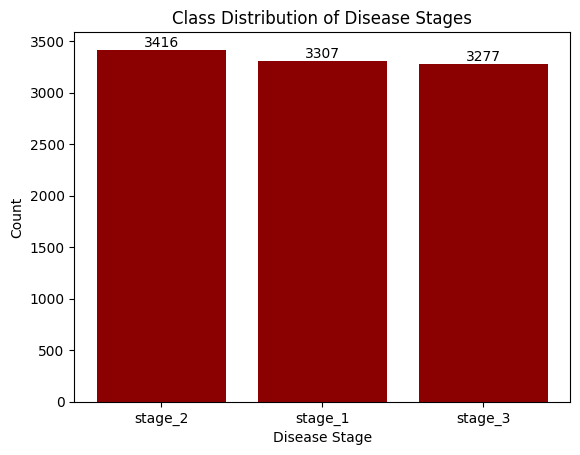

In [6]:
#Displaying a bar chart showing class distribution
counts = df['Disease_Stage'].value_counts()
plt.bar(counts.index, counts.values, color='darkred')
plt.xlabel('Disease Stage')
plt.ylabel('Count')
plt.title('Class Distribution of Disease Stages')

for i, (stage, count) in enumerate(zip(counts.index, counts.values)):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

# Step Two: Data Preparation

In [ ]:
#Chacking for missing values.
df.isnull().sum()

,0
N_Days,18
Status,107
Drug,0
Age,25
Gender,44
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0


In [ ]:
#Using SimpleImputer is replace all null values in numerical columns with the mean of non-missing values in that column.
num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df['N_Days'] = num_imputer.fit_transform(df[['N_Days']])
df['Age'] = num_imputer.fit_transform(df[['Age']])

In [ ]:
#Using SimpleImputer to replace all null values in categorical columns with the most frequent values of non-missing values in that column.
str_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Status'] = str_imputer.fit_transform(df[['Status']]).ravel()
df['Gender'] = str_imputer.fit_transform(df[['Gender']]).ravel()

In [ ]:
#Checking for null values again.
df.isnull().sum()

,0
N_Days,0
Status,0
Drug,0
Age,0
Gender,0
Ascites,0
Hepatomegaly,0
Spiders,0
Edema,0
Bilirubin,0


In [ ]:
#Performing one-hot encoding to encode any features containing non numerical categorical values.
df = pd.get_dummies(df, columns=['Status', 'Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin'], dtype=int)

In [ ]:
#Using label encoding to encode the target column's (disease stage) categories into numerical values that our models can predict.
label_encode = LabelEncoder()
df['Disease_Stage'] = label_encode.fit_transform(df['Disease_Stage'])

In [ ]:
df.head()

,N_Days,Age,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Disease_Stage,Status_C,Status_CL,Status_D,Drug_D-penicillamine,Drug_Placebo,Gender_F,Gender_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Bilirubin_0.3,Bilirubin_0.4,Bilirubin_0.5,Bilirubin_0.6,Bilirubin_0.7,Bilirubin_0.8,Bilirubin_0.9,Bilirubin_1.0,Bilirubin_1.1,Bilirubin_1.2,Bilirubin_1.3,Bilirubin_1.4,Bilirubin_1.5,Bilirubin_1.6,Bilirubin_1.7,Bilirubin_1.8,Bilirubin_1.9,Bilirubin_2.0,Bilirubin_2.1,Bilirubin_2.2,Bilirubin_2.3,Bilirubin_2.4,Bilirubin_2.5,Bilirubin_2.6,Bilirubin_2.7,Bilirubin_2.8,Bilirubin_2.9,Bilirubin_3.0,Bilirubin_3.1,Bilirubin_3.2,Bilirubin_3.3,Bilirubin_3.4,Bilirubin_3.5,Bilirubin_3.6,Bilirubin_3.7,Bilirubin_3.8,Bilirubin_3.9,Bilirubin_4.0,Bilirubin_4.2,Bilirubin_4.4,Bilirubin_4.5,Bilirubin_4.6,Bilirubin_4.7,Bilirubin_5.0,Bilirubin_5.1,Bilirubin_5.2,Bilirubin_5.4,Bilirubin_5.5,Bilirubin_5.6,Bilirubin_5.7,Bilirubin_5.8,Bilirubin_5.9,Bilirubin_6.0,Bilirubin_6.1,Bilirubin_6.3,Bilirubin_6.4,Bilirubin_6.5,Bilirubin_6.6,Bilirubin_6.7,Bilirubin_6.8,Bilirubin_6.9,Bilirubin_7.1,Bilirubin_7.2,Bilirubin_7.3,Bilirubin_8.0,Bilirubin_8.1,Bilirubin_8.4,Bilirubin_8.5,Bilirubin_8.6,Bilirubin_8.7,Bilirubin_8.9,Bilirubin_9.0,Bilirubin_9.5,Bilirubin_10.0,Bilirubin_10.4,Bilirubin_10.8,Bilirubin_11.0,Bilirubin_11.1,Bilirubin_11.2,Bilirubin_11.4,Bilirubin_11.5,Bilirubin_11.7,Bilirubin_11.9,Bilirubin_12.0,Bilirubin_12.1,Bilirubin_12.2,Bilirubin_12.6,Bilirubin_13.0,Bilirubin_13.6,Bilirubin_13.8,Bilirubin_14.0,Bilirubin_14.1,Bilirubin_14.4,Bilirubin_14.5,Bilirubin_15.0,Bilirubin_16.0,Bilirubin_16.2,Bilirubin_17.0,Bilirubin_17.1,Bilirubin_17.2,Bilirubin_17.4,Bilirubin_17.9,Bilirubin_18.0,Bilirubin_20.0,Bilirubin_21.6,Bilirubin_22.5,Bilirubin_24.5,Bilirubin_25.5,Bilirubin_28.0
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10481,2772.0,16071.0,217.0,3.62,13.0,414.0,75.95,119.0,292.0,10.2,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19109,1234.0,21185.0,373.0,3.46,155.0,1768.0,120.00,151.0,109.0,10.4,2,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14801,1349.0,12285.0,572.0,3.77,77.0,2520.0,92.00,114.0,226.0,11.7,2,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22491,4196.0,17841.0,258.0,3.57,79.0,2201.0,120.90,76.0,410.0,11.5,2,1,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8594,2443.0,16050.0,308.0,3.69,67.0,696.0,51.15,101.0,278.0,9.9,2,1,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Step 3: Model Preparation

In [ ]:
#Separating the independent and dependent variables for our models.
X = df.drop('Disease_Stage', axis=1)
Y = df['Disease_Stage']

In [ ]:
# Standardizing features to improve model performance by scaling them to the same range.
X_standardized = (X - X.mean()) / X.std()

In [ ]:
#Sample of standardized features.
X_standardized.sample(20)

,N_Days,Age,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Status_C,Status_CL,Status_D,Drug_D-penicillamine,Drug_Placebo,Gender_F,Gender_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Bilirubin_0.3,Bilirubin_0.4,Bilirubin_0.5,Bilirubin_0.6,Bilirubin_0.7,Bilirubin_0.8,Bilirubin_0.9,Bilirubin_1.0,Bilirubin_1.1,Bilirubin_1.2,Bilirubin_1.3,Bilirubin_1.4,Bilirubin_1.5,Bilirubin_1.6,Bilirubin_1.7,Bilirubin_1.8,Bilirubin_1.9,Bilirubin_2.0,Bilirubin_2.1,Bilirubin_2.2,Bilirubin_2.3,Bilirubin_2.4,Bilirubin_2.5,Bilirubin_2.6,Bilirubin_2.7,Bilirubin_2.8,Bilirubin_2.9,Bilirubin_3.0,Bilirubin_3.1,Bilirubin_3.2,Bilirubin_3.3,Bilirubin_3.4,Bilirubin_3.5,Bilirubin_3.6,Bilirubin_3.7,Bilirubin_3.8,Bilirubin_3.9,Bilirubin_4.0,Bilirubin_4.2,Bilirubin_4.4,Bilirubin_4.5,Bilirubin_4.6,Bilirubin_4.7,Bilirubin_5.0,Bilirubin_5.1,Bilirubin_5.2,Bilirubin_5.4,Bilirubin_5.5,Bilirubin_5.6,Bilirubin_5.7,Bilirubin_5.8,Bilirubin_5.9,Bilirubin_6.0,Bilirubin_6.1,Bilirubin_6.3,Bilirubin_6.4,Bilirubin_6.5,Bilirubin_6.6,Bilirubin_6.7,Bilirubin_6.8,Bilirubin_6.9,Bilirubin_7.1,Bilirubin_7.2,Bilirubin_7.3,Bilirubin_8.0,Bilirubin_8.1,Bilirubin_8.4,Bilirubin_8.5,Bilirubin_8.6,Bilirubin_8.7,Bilirubin_8.9,Bilirubin_9.0,Bilirubin_9.5,Bilirubin_10.0,Bilirubin_10.4,Bilirubin_10.8,Bilirubin_11.0,Bilirubin_11.1,Bilirubin_11.2,Bilirubin_11.4,Bilirubin_11.5,Bilirubin_11.7,Bilirubin_11.9,Bilirubin_12.0,Bilirubin_12.1,Bilirubin_12.2,Bilirubin_12.6,Bilirubin_13.0,Bilirubin_13.6,Bilirubin_13.8,Bilirubin_14.0,Bilirubin_14.1,Bilirubin_14.4,Bilirubin_14.5,Bilirubin_15.0,Bilirubin_16.0,Bilirubin_16.2,Bilirubin_17.0,Bilirubin_17.1,Bilirubin_17.2,Bilirubin_17.4,Bilirubin_17.9,Bilirubin_18.0,Bilirubin_20.0,Bilirubin_21.6,Bilirubin_22.5,Bilirubin_24.5,Bilirubin_25.5,Bilirubin_28.0
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2313,1.212542,-2.367895,-0.020514,1.061235,-0.027051,-0.005996,-0.009921,0.038922,1.694583,-0.702410,0.899202,-0.289426,-0.765989,1.322628,-1.322628,0.355303,-0.355303,0.697494,-0.697494,0.796864,-0.796864,0.916983,-0.916983,0.478468,-0.410796,-0.209112,-0.052987,-0.149627,-0.252633,-0.261257,-0.286167,-0.271801,-0.220075,-0.182980,-0.241932,5.346302,-0.227223,-0.146452,-0.115651,-0.116976,-0.115207,-0.180041,-0.090923,-0.125469,-0.126289,-0.107379,-0.107855,-0.077689,-0.093678,-0.042463,-0.06723,-0.074363,-0.078338,-0.090923,-0.086339,-0.110202,-0.092034,-0.143939,-0.080882,-0.105941,-0.036077,-0.030012,-0.060937,-0.071594,-0.055761,-0.051054,-0.080253,-0.03466,-0.072296,-0.105941,-0.063369,-0.051054,-0.049046,-0.061759,-0.061759,-0.053927,-0.01,-0.057538,-0.055761,-0.045872,-0.060937,-0.090362,-0.033183,-0.087507,-0.042463,-0.045872,-0.01,-0.070169,-0.058406,-0.09148,-0.04003,-0.042463,-0.042463,-0.07368,-0.038757,-0.097408,-0.067976,-0.026465,-0.036077,-0.01,-0.01,-0.054852,-0.081506,-0.054852,-0.01,-0.058406,-0.014143,-0.01,-0.01,-0.024501,-0.01,-0.031637,-0.061759,-0.053927,-0.022365,-0.043628,-0.070169,-0.066476,-0.058406,-0.03466,-0.046953,-0.063369,-0.033183,-0.01,-0.048011,-0.074363,-0.117414,-0.024501,-0.024501,-0.067976,-0.070885,-0.056656,-0.03466,-0.042463,-0.063369
3985,1.107065,-0.585268,-0.629594,1.270641,0.994434,-0.753724,-1.295695,-0.749402,-0.553897,-0.702410,0.899202,-0.289426,-0.765989,1.322628,-1.322628,0.355303,-0.355303,0.697494,-0.697494,0.796864,-0.796864,0.916983,-0.916983,0.478468,-0.410796,-0.209112,-0.052987,-0.149627,-0.252633,-0.261257,-0.286167,-0.271801,4.543452,-0.182980,-0.241932,-0.187026,-0.227223,-0.146452,-0.115651,-0.116976,-0.115207,-0.180041,-0.090923,-0.125469,-0.126289,-0.107379,-0.107855,-0.077689,-0.093678,-0.042463,-0.06723,-0.074363,-0.078338,-0.090923,-0.086339,-0.110202,-0.092034,-0.143939,-0.080882,-0.105941,-0.036077,-0.030012,-0.060937,-0.071594,-0.055761,-0.051054,-0.080253,-0.03466,-0.072296,-0.105941,-0.063369,-0.051054,-0.049046,-0.0617

In [ ]:
#Sample of dependent variables for the model.
Y.sample(5)

,Disease_Stage
Patient_ID,
12618,0
2294,1
12323,1
13358,2
13676,2


#Step 4: Training the Model

In [ ]:
#Splitting the data into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y, stratify=Y, random_state=36)

###Logistic Regression Model

In [ ]:
#Training a logistic regression model with L2 regularization (Prevent overfitting by penalizing large weights).
logistic_reg = LogisticRegression(random_state=36, penalty='l2', solver='lbfgs', C=1.0)
logistic_reg.fit(X_train, Y_train)

LogisticRegression(random_state=36)

In [ ]:
#Checking the accuracy of the model.
accuracy = logistic_reg.score(X_test, Y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 68.40%


### KNN Model

In [ ]:
#Training a k-Nearest Neighbors classifier with 7 neighbors, distance-based weighting, and cosine similarity as the distance metric.
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='cosine')
knn.fit(X_train, Y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

In [ ]:
#Checking the accuracy of the model.
knn_accuracy = knn.score(X_test, Y_test)
print(f'Accuracy: {knn_accuracy*100:.2f}%')

Accuracy: 88.12%


###Random Forest Model

In [ ]:
#Training a Random Forest classifier with 300 trees and a minimum of 4 samples per leaf for better generalization.
rf = RandomForestClassifier(n_estimators=300, min_samples_leaf=4, random_state=36)
rf.fit(X_train, Y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=300, random_state=36)

### Evaluate Random Forest model

In [ ]:
#Checking the accuracy of the model.
rf_accuracy = rf.score(X_test, Y_test)
print(f'Accuracy: {rf_accuracy*100:.2f}%')

Accuracy: 91.40%


###Support Vector Classifier Model

In [ ]:
#Training a Support Vector Classifier with a linear kernel and regularization strength C=2.
svc = SVC(kernel='linear', C=2, random_state=36)
svc.fit(X_train, Y_train)

SVC(C=2, kernel='linear', random_state=36)

In [ ]:
#Checking the accuracy of the model.
svc_accuracy = rf.score(X_test, Y_test)
print(f'Accuracy: {svc_accuracy*100:.2f}%')

Accuracy: 91.40%


#Step 5: Model Evaluations and Analysis

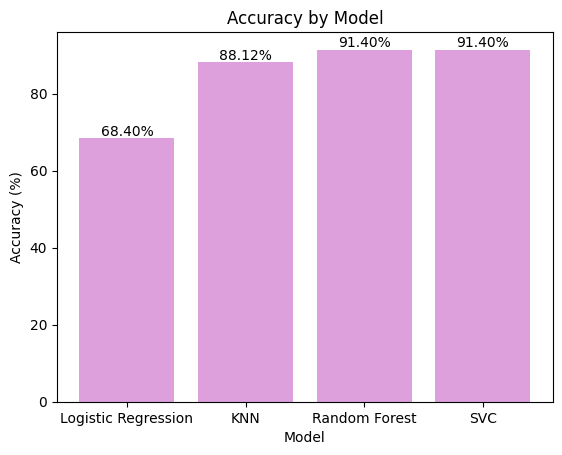

In [ ]:
#Visualizing model accuracy scores using a bar chart.
plt.bar(['Logistic Regression', 'KNN', 'Random Forest', 'SVC'], [accuracy*100, knn_accuracy*100, rf_accuracy*100, svc_accuracy*100], color='plum')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Model')
for i, (model, acc) in enumerate(zip(['Logistic Regression', 'KNN', 'Random Forest', 'SVC'], [accuracy*100, knn_accuracy*100, rf_accuracy*100, svc_accuracy*100])):
  plt.text(i, acc, f'{acc:.2f}%', ha='center', va='bottom')
plt.show()

According to the accuracy comparison, logistic regression performed the worst with an accuracy of 68.40%, while other models such as KNN, Random Forest, and SVC performed significantly better. This may be due to the limitations of logistic regression, as it assumes a linear relationship between the features and the target variable (Disease Stage), which might not accurately reflect the complexity of the data.

KNN's higher accuracy (88.12%) suggests that the dataset benefits from local similarity measures, where predictions are influenced by nearby data points. Random Forest and SVC, both achieving 91.40% accuracy, indicate their ability to handle non-linear relationships and complex patterns in the data effectively. Random Forest likely benefits from its ensemble nature, combining multiple decision trees to reduce overfitting, while SVC's use of hyperplanes allows it to separate data points even in non-linear spaces.

The conclusion we can draw is that Random Forest and SVC are the most suitable models for predicting Liver Cirrhosis Stages, each achieving the highest accuracy of 91.40%. Random Forest benefits from its ensemble approach, combining multiple decision trees to reduce overfitting and enhance robustness, while SVC excels at separating data points in non-linear spaces using hyperplanes. Given their strong performance, these models should be prioritized for deployment, with additional steps such as hyperparameter tuning and cross-validation to further optimize their accuracy and ensure generalizability.